# Zomato Sales Analysis

---

### Install the Packages

In [1]:
!pip install psycopg2-binary pandas scikit-learn matplotlib

### Import Packages

In [2]:
# Import Packges
import pandas as pd
import psycopg2
import json
from psycopg2 import sql
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Import data from PostgreSQL

In [4]:
with open("./config.json") as f:
    config = json.load(f)

In [5]:
import os
db_user = os.getenv("DB_USER", config.get("db_user"))
db_pass = os.getenv("DB_PASSWORD", str(config.get("db_pass", "")))
db_host = os.getenv("DB_HOST", config.get("db_host", "localhost"))
db_port = int(os.getenv("DB_PORT", config.get("db_port", 5432)))
db_name = os.getenv("DB_NAME", config.get("db_name"))

In [6]:
conn = psycopg2.connect( host = db_host,
                      dbname = db_name,
                      user=db_user,
                      password = db_pass,
                      port=db_port)
    
cur = conn.cursor()
def fetch_table_to_df(table_name):
    # Whitelist of allowed table names
    allowed_tables = ['riders', 'orders', 'restaurants', 'customers', 'delivery']
    if table_name not in allowed_tables:
        raise ValueError(f"Invalid table name: {table_name}")
    cur.execute(sql.SQL("SELECT * FROM {}").format(sql.Identifier(table_name)))
    rows = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    df = pd.DataFrame(rows, columns=colnames)
    return df

riders_df = fetch_table_to_df('riders')
orders_df = fetch_table_to_df('orders')
restaurants_df = fetch_table_to_df('restaurants')
customers_df = fetch_table_to_df('customers')
delivery_df = fetch_table_to_df('delivery')

conn.close()

In [7]:
for tab in [riders_df, orders_df, restaurants_df, customers_df, delivery_df]:
    print(tab.columns)

Index(['rider_id', 'rider_name', 'sign_up'], dtype='object')
Index(['order_id', 'customer_id', 'restaurant_id', 'order_item', 'order_date',
       'order_time', 'order_status', 'total_amount'],
      dtype='object')
Index(['restaurant_id', 'restaurant_name', 'city', 'opening_hours'], dtype='object')
Index(['customer_id', 'customer_name', 'reg_date'], dtype='object')
Index(['delivery_id', 'order_id', 'delivery_status', 'delivery_time',
       'rider_id'],
      dtype='object')


### 1. FIND THE TOP 5 MOST FREQUENTLY ORDERED DISHES BY CUSTOMER CALLED 'Jayant Solanki' IN THE LAST 1 YEAR.

In [14]:
cust = customers_df[customers_df['customer_name'] == 'Jayant Solanki']

if not cust.empty:
    cust_id = cust.iloc[0]['customer_id']

    # 2. Filter orders from last 1 year for Arjun
    from datetime import timedelta
    orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')
    one_year_ago = pd.to_datetime('today') - timedelta(days=365)

    cust_orders = orders_df[
        (orders_df['customer_id'] == cust_id) & 
        (orders_df['order_date'] >= one_year_ago)
    ]

    # 3. Get top 5 dishes
    top_dishes = cust_orders['order_item'].value_counts().head(5).reset_index()
    top_dishes.columns = ['dish_name', 'order_count']

    print("Top 5 Most Ordered Dishes by Jayant Solanki (Last 1 Year):\n")
    print(top_dishes)

else:
    print("Jayant Solanki wasn't found in the customers dataset.")


Top 5 Most Ordered Dishes by Jayant Solanki (Last 1 Year):

              dish_name  order_count
0           Butter Naan           10
1  Paneer Butter Masala            8
2      Tandoori Chicken            8
3           Dal Makhani            7
4    Hyderabadi Biryani            7


### 2. ORDER VALUE ANALYSIS - FIND THE AVERAGE ORDER VALUE PER CUSTOMER WHO HAS PLACED MORE THEN 90 ORDERS

In [13]:
# 1. Group orders by customer_id: count & average
order_stats = orders_df.groupby('customer_id').agg(
    order_count=('order_id', 'count'),
    avg_order_value=('total_amount', 'mean')
).reset_index()

# 2. Filter customers with more than 180 orders
high_volume_customers = order_stats[order_stats['order_count'] > 90]

# 3. Merge with customer names
high_volume_customers = pd.merge(
    high_volume_customers,
    customers_df[['customer_id', 'customer_name']],
    on='customer_id',
    how='left'
)

# 4. Keep only required columns
result = high_volume_customers[['customer_name', 'avg_order_value']].sort_values(
    by='avg_order_value',
    ascending=False
).reset_index(drop=True)

# 5. Round for readability
result['avg_order_value'] = result['avg_order_value'].round(2)

print("Average Order Value for Customers with >180 Orders:\n")
print(result.head(10)) 


Average Order Value for Customers with >180 Orders:

    customer_name  avg_order_value
0   Kartik Talwar           933.62
1      Mishti Lal           933.59
2   Aradhya Ratti           930.16
3    Aarna Kamdar           927.18
4    Sumer Bhalla           924.81
5      Amira Toor           924.31
6  Azad Rajagopal           923.70
7   Onkar Chhabra           922.99
8     Abram Sethi           921.50
9       Zoya Buch           917.24


### 3.  HIGH VALUE CUSTOMERS - LIST THE CUSTOMERS WHO HAVE SPENT MORE THEN 100K IN TOTAL ON FOOD ORDERS

In [12]:
# 1. Calculate total spend per customer
total_spend = orders_df.groupby('customer_id')['total_amount'].sum().reset_index()

# 2. Filter those who spent more than 100K
high_value_customers = total_spend[total_spend['total_amount'] > 100000]

# 3. Merge with customer names
high_value_customers = pd.merge(
    high_value_customers,
    customers_df[['customer_id', 'customer_name']],
    on='customer_id',
    how='left'
)

# 4. Select and rename columns
result = high_value_customers[['customer_id', 'customer_name']].sort_values(by='customer_id')

print("High Value Customers (Spent > ₹100,000):\n")
print(result)


High Value Customers (Spent > ₹100,000):

     customer_id      customer_name
0             11       Riya Kothari
1            224      Prerak Sunder
2            284        Aarav Joshi
3            301         Tara Reddy
4            486       Alia Chandra
..           ...                ...
148         9664     Aaryahi Sarraf
149         9931          Shlok Dey
150         9973    Lakshay Sachdev
151         9978  Vaibhav Chowdhury
152         9992         Anahi Vora

[153 rows x 2 columns]


### 4. ORDERS WITHOUT DELIVERY - WRITE A QUERY TO FIND ORDERS THAT WERE PLACED BUT NOT DELIVERED

In [11]:
# 1. Get order_ids that are NOT in delivery table
undelivered_orders = orders_df[~orders_df['order_id'].isin(delivery_df['order_id'])]

# 2. Count undelivered orders per restaurant_id
undelivered_counts = undelivered_orders.groupby('restaurant_id')['order_id'].count().reset_index()
undelivered_counts.rename(columns={'order_id': 'not_delivered_count'}, inplace=True)

# 3. Merge with restaurant info
undelivered_summary = pd.merge(
    undelivered_counts,
    restaurants_df[['restaurant_id', 'restaurant_name', 'city']],
    on='restaurant_id',
    how='left'
)

# 4. Rearrange columns
undelivered_summary = undelivered_summary[['restaurant_name', 'city', 'not_delivered_count']]

# 5. Sort by highest number of undelivered orders
undelivered_summary = undelivered_summary.sort_values(by='not_delivered_count', ascending=False).reset_index(drop=True)

print("Orders Placed but Not Delivered:\n")
print(undelivered_summary.head(10))


Orders Placed but Not Delivered:

                          restaurant_name       city  not_delivered_count
0       Karavalli - Ahmedabad Branch 6026  Ahmedabad                  248
1        Indian Accent - Pune Branch 7366       Pune                  243
2      Paradise Biryani - Goa Branch 6333        Goa                  236
3       Dum Pukht - Bangalore Branch 9485  Bangalore                  235
4    Oh! Calcutta - Hyderabad Branch 2265  Hyderabad                  235
5       Copper Chimney - Pune Branch 7259       Pune                  235
6  Mainland China - Bangalore Branch 8557  Bangalore                  234
7         Indian Accent - Goa Branch 8770        Goa                  233
8        Annalakshmi - Jaipur Branch 1644     Jaipur                  233
9  The Bombay Canteen - Delhi Branch 6362      Delhi                  232


Several well-known restaurants across major cities have a high number of undelivered orders, with Karavalli - Ahmedabad topping the list at 248 undelivered orders. Pune, Goa, and Bangalore appear multiple times, suggesting potential logistics or operational bottlenecks in these regions. Notably, Indian Accent and Paradise Biryani have multiple branches with high counts, which may indicate recurring issues with specific chains. This trend warrants deeper investigation into delivery workflows, vendor coordination, or customer drop-offs to reduce loss and improve customer satisfaction.

### 5. CUSTOMER CHURN - FIND CUSTOMERS WHO HAVEN'T PLACED AN ORDER IN 2025 BUT DID IN 2024

In [10]:
# Ensure 'order_date' is in datetime format
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# 1. Filter orders in 2023
orders_2024 = orders_df[(orders_df['order_date'].dt.year == 2024)]
customers_2024 = set(orders_2024['customer_id'])

# 2. Filter orders in 2024
orders_2025 = orders_df[(orders_df['order_date'].dt.year == 2025)]
#print(orders_2024)
customers_2025 = set(orders_2025['customer_id'])

# 3. Customers who ordered in 2023 but not in 2024
churned_customers = customers_2024 - customers_2025

# 4. Get customer names and IDs
churned_df = customers_df[customers_df['customer_id'].isin(churned_customers)][['customer_id', 'customer_name']]

# 5. Output the churned customers
print("Churned Customers (2024 active, no orders in 2025):")
print(churned_df.head(10))


Churned Customers (2024 active, no orders in 2025):
Empty DataFrame
Columns: [customer_id, customer_name]
Index: []


# Customer Segmentation

In [15]:
# Step 1: Merge orders with customers
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])
merged_df = orders_df.merge(customers_df, on='customer_id', how='left')

# Step 2: Group by customer_id to get metrics
customer_metrics = merged_df.groupby(['customer_id', 'customer_name']).agg(
    total_orders = ('order_id', 'count'),
    total_spend = ('total_amount', 'sum'),
    avg_order_value = ('total_amount', 'mean'),
    last_order_date = ('order_date', 'max')
).reset_index()

# Step 3: Add recency in days
from datetime import datetime
today = pd.to_datetime("today")
customer_metrics['recency_days'] = (today - customer_metrics['last_order_date']).dt.days

# Step 4: Segment based on rules
def segment_customer(row):
    if row['total_spend'] > 100000 and row['total_orders'] > 200:
        return 'High-Value Loyal'
    elif row['total_orders'] > 150:
        return 'Frequent Buyer'
    elif row['recency_days'] > 180:
        return 'At Risk'
    elif row['total_orders'] < 10:
        return 'Occasional Buyer'
    else:
        return 'Regular Buyer'

customer_metrics['segment'] = customer_metrics.apply(segment_customer, axis=1)

# Step 5: View the segments
segment_counts = customer_metrics['segment'].value_counts()
print("Segment Breakdown:\n", segment_counts)

# Optional: View sample of each segment
for seg in customer_metrics['segment'].unique():
    print(f"\n Sample from segment: {seg}")
    print(customer_metrics[customer_metrics['segment'] == seg].head(3))


Segment Breakdown:
 segment
Regular Buyer    10000
Name: count, dtype: int64

 Sample from segment: Regular Buyer
   customer_id customer_name  total_orders  total_spend  avg_order_value  \
0            1     Hazel Lad            97     74644.73       769.533299   
1            2  Biju Sampath           105     88343.01       841.362000   
2            3   Gatik Vohra            95     76167.09       801.758842   

  last_order_date  recency_days        segment  
0      2025-05-27            76  Regular Buyer  
1      2025-05-27            76  Regular Buyer  
2      2025-05-22            81  Regular Buyer  


In [ ]:
# Count total orders placed by each customer
customer_order_counts = orders_df.groupby('customer_id').size().reset_index(name='total_orders')

print(customer_order_counts.head())
orders_df

   customer_id  total_orders
0            1            97
1            2           105
2            3            95
3            4           101
4            5           107


,order_id,customer_id,restaurant_id,order_item,order_date,order_time,order_status,total_amount
0,1,3009,345,Masala Dosa,2024-07-16,17:11:37,completed,649.33
1,2,2819,235,Pasta Alfredo,2024-07-28,10:56:54,completed,221.85
2,3,7980,631,Spring Rolls,2025-05-14,12:15:50,completed,1439.30
3,4,7055,9,Tandoori Chicken,2025-05-06,00:41:22,pending,548.19
4,5,5575,350,Tandoori Chicken,2025-05-17,13:25:18,completed,1261.91
...,...,...,...,...,...,...,...,...
999995,999996,1929,35,Mutton Rogan Josh,2024-10-10,19:29:10,completed,1326.56
999996,999997,122,456,Chicken Biryani,2024-09-07,06:55:43,cancelled,1190.45
999997,999998,3745,498,Masala Dosa,2024-07-28,23:13:32,in_progress,532.49
999998,999999,810,752,Chicken Shawarma,2024-12-09,13:41:03,completed,955.51


In [64]:
orders_df[orders_df['customer_id']==3009].groupby('order_item').count()

,order_id,customer_id,restaurant_id,order_date,order_time,order_status,total_amount
order_item,,,,,,,
Butter Naan,3,3,3,3,3,3,3
Chicken Biryani,11,11,11,11,11,11,11
Chicken Shawarma,6,6,6,6,6,6,6
Chole Bhature,5,5,5,5,5,5,5
Dal Makhani,9,9,9,9,9,9,9
Fish Curry,8,8,8,8,8,8,8
Hyderabadi Biryani,12,12,12,12,12,12,12
Margherita Pizza,7,7,7,7,7,7,7
Masala Dosa,10,10,10,10,10,10,10


### Menu Recommendation

In [22]:
# -------- STEP 1: Create User-Item Matrix --------
# Count how many times each customer ordered each item
user_item_matrix = orders_df.groupby(['customer_id', 'order_item']) \
                            .size() \
                            .unstack(fill_value=0)

# -------- STEP 2: Compute Cosine Similarity Between Users --------
user_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

# -------- STEP 3: Function --------
def recommend_dishes(customer_id, top_n=1):
    if customer_id not in user_similarity.index:
        return f"Customer ID {customer_id} not found in dataset."

    # Find top 5 similar users (excluding the customer themselves)
    similar_users = user_similarity[customer_id] \
                     .sort_values(ascending=False) \
                     .drop(customer_id) \
                     .head(5)

    if similar_users.empty:
        return f"No similar users found for Customer {customer_id}."

    # Combine orders from similar users
    similar_users_orders = user_item_matrix.loc[similar_users.index]

    # Get average frequency of items ordered by similar users
    mean_order_scores = similar_users_orders.mean(axis=0)

    # Filter out items already ordered by the customer
    customer_orders = user_item_matrix.loc[customer_id]
    dishes_not_ordered = mean_order_scores[customer_orders == 0]

    if dishes_not_ordered.empty:
        return f"No new dishes to recommend for Customer {customer_id}."

    # Recommend top N dishes
    recommendations = dishes_not_ordered.sort_values(ascending=False).head(top_n)

    return recommendations.index.tolist()

sample_customer_id = 3009  

recommendations = recommend_dishes(sample_customer_id)

print(f"Recommended dishes for customer {sample_customer_id}:")
print(recommendations)


Recommended dishes for customer 3009:
No new dishes to recommend for Customer 3009.


### Price Forecasting

In [23]:
# STEP 1: Group by dish and calculate price statistics
price_stats = orders_df.groupby('order_item')['total_amount'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index()
price_stats = price_stats.rename(columns={
    'count': 'times_ordered',
    'mean': 'avg_price',
    'median': 'median_price',
    'min': 'min_price',
    'max': 'max_price'
})

# STEP 2: Recommendation function
def recommend_price_for_dish(dish_name):
    dish_row = price_stats[price_stats['order_item'] == dish_name]

    if dish_row.empty:
        return f"No pricing data found for '{dish_name}'."
    
    dish_info = dish_row.iloc[0]
    return {
        'Dish': dish_name,
        'Recommended Price (avg)': round(dish_info['avg_price'], 2),
        'Median Price': round(dish_info['median_price'], 2),
        'Lowest Seen': round(dish_info['min_price'], 2),
        'Highest Seen': round(dish_info['max_price'], 2),
        'Total Times Ordered': int(dish_info['times_ordered'])
    }

# STEP 3: Try the recommender
example_dish = "Masala Dosa"
recommended_price = recommend_price_for_dish(example_dish)

print("Price Recommendation:")
for k, v in recommended_price.items():
    print(f"{k}: {v}")


Price Recommendation:
Dish: Masala Dosa
Recommended Price (avg): 799.84
Median Price: 800.93
Lowest Seen: 100.01
Highest Seen: 1499.99
Total Times Ordered: 66289


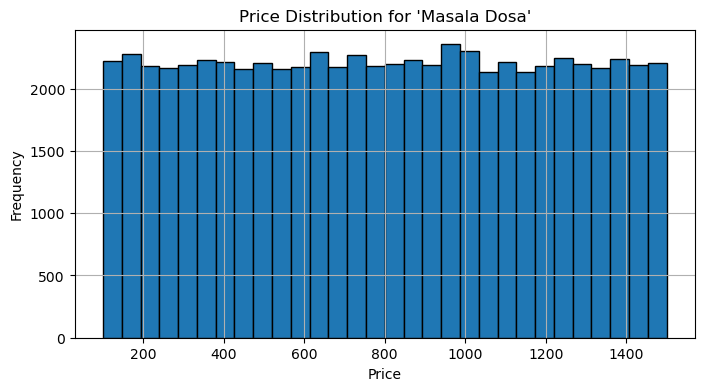

In [ ]:
def plot_price_distribution(dish_name):
    dish_prices = orders_df[orders_df['order_item'] == dish_name]['total_amount']
    
    if dish_prices.empty:
        print(f"No data to plot for '{dish_name}'")
        return
    
    plt.figure(figsize=(8,4))
    plt.hist(dish_prices, bins=30, edgecolor='black')
    plt.title(f"Price Distribution for '{dish_name}'")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Try plotting
plot_price_distribution("Masala Dosa")
